# SELECTING MOUSE TRANSCRIPTS (VERSION 2)
November 4, 2020

Here we explain our strategy in building the second version of the RiboFlow mouse transcript.

We revisit our reference building strategy using the most recent (as of the writing of this document) version of [APPRIS](http://appris-tools.org/) principal isoforms. 
In particular, our appris list uses GENCODE [M25](https://www.gencodegenes.org/mouse/release_M25.html).

While we followed our former strategy, we decided to make slight modifications to make our transcript picking method more inclusive. Namely, in the new version we allow transcripts to have empty (5' or 3') UTRs. 

In [1]:
! ls ..

raw  riboflow_annot_and_ref  scripts


In [2]:
# PYTHON MODULES
import sys
import os
from collections import defaultdict
import gzip

import matplotlib
#from matplotlib_venn import venn2, venn2_unweighted
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from IPython.display import Markdown as md
from IPython.core.display import HTML as Center
from IPython.display import display_html


sys.path.insert(0, '../../../..')
import ref_lib
from ref_lib.Fasta import FastaFile, FastaEntry
from ref_lib.GTF import GTFfile, GTFEntry, get_gtf_contents

%matplotlib inline

import IPython

# Some formatting forthe rest of the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Reference and annotations files we'll be using:

In [3]:
transcripts_fasta = "../raw/sequence/gencode.vM25.pc_transcripts.fa.gz"
gencode_gtf       = "../raw/annotation/gencode.vM25.annotation.gtf.gz"
appris_file       = "../raw/annotation/appris_data.principal.txt"

GENCODE gtf contents are stored in a dictionary. It might take a while to read all gtf:

In [4]:
gtf_all = get_gtf_contents( gencode_gtf )

We define the functions to extract CDS and UTR coordinates relative ro the transcript start. These care stored in the gtf_all dictionary with "bed_" prefix.

In [5]:
def _find_rel_cds_end_coords( exon_list, cds_contents, coord_type, strand ):
    """
    Returns the start or end of the CDS 0-based bed format
    So the start position is included and end position is excluded
    """    
    # c is the corresponding_exon_index to the cds chunk
    
    if coord_type == "start":
        cds_chunk = cds_contents[0]
        c = cds_chunk[2]
        if strand == "+":
            this_sum = cds_chunk[0] - exon_list[c][0]
        else:
            this_sum = exon_list[c][1] - cds_chunk[1]
    else:
        cds_chunk = cds_contents[-1]
        c = cds_chunk[2]
        this_sum = (cds_chunk[1] - cds_chunk[0]) + 1
        
        if len(cds_contents) == 1:
            if strand == "+":
                this_sum += cds_chunk[0]  - exon_list[c][0]  
            else:
                this_sum += exon_list[c][1] - cds_chunk[1]
        """
        Delete this later!!!
        if strand == "+":
            this_sum = (cds_chunk[1] - cds_chunk[0]) + 1
        else:
            this_sum = cds_chunk[0] - exon_list[c][0]
        """
    for e in exon_list[:c]:
        this_sum += (e[1] - e[0]) + 1
        
    return this_sum


def find_rel_utr_cds_positions( genes_dict ):
    """
    For each transcri,pt, the first nucleotide (of the transcript) has position 0
    the coordinates are in BED stye
    so For A,B 
    A: start, is INCLUDED
    B: end, is EXCLUDED
    The coordinates have the _bed prefix and they are stored in
    the corresponding transcript dictionary
    """
    # 
    # 0-based and end coordinate is excluded
    # 
    for g_name, transcripts in genes_dict.items():
    
        for t_name, t_contents in transcripts.items():
            CDS_contents = t_contents.get("CDS", list())
            if len(CDS_contents) == 0:
                continue

            cds_rel_start = \
                _find_rel_cds_end_coords( t_contents["exons"], CDS_contents, "start", t_contents["strand"]   )
            cds_rel_end = \
                _find_rel_cds_end_coords( t_contents["exons"], CDS_contents, "end", t_contents["strand"] )
        
            t_length = t_contents["length"]
                
            t_contents["bed_CDS"] = ( cds_rel_start, cds_rel_end )
            if cds_rel_start > 0:
                t_contents["bed_UTR_5"] = (0, cds_rel_start  )
                
            if cds_rel_end < t_length:
                t_contents["bed_UTR_3"] = (cds_rel_end, t_length )

In [6]:
find_rel_utr_cds_positions(gtf_all)

## Selecting Longest Appris Transcripts

When going through Appris transcripts, we pick only the ones labeled with the label "PRINCIPAL".

In [7]:
def read_principal_appris_trascript_list(appris_file, gtf_contents):
    """
    Reads the appris isoform file into a dictionary
    
    We assume that the files is of the form:
    Gene NAme \t GENE_ID \t TRANSCRIOPT_ID \t APPRIS_CATEGORY
    # C1orf112	ENSG00000000460	ENST00000286031	CCDS1285	PRINCIPAL:1
    
    The output dictionary is of the form:
    appris_genes[gene_id][transcript_id] = {  "gene_name": gene_name, "category": category }
    """
    
    appris_genes = defaultdict(dict)
    myopen=open
    if appris_file.endswith(".gz"):
        myopen = gzip.open
    
    with myopen(appris_file, "rt") as input_stream:
        for entry in input_stream:
            contents = entry.strip().split()
            if len(contents) < 5:
                continue
            gene_name, gene_id, transcript_id, dummy, category = contents
            if not category.startswith("PRINCIPAL"):
                continue
            appris_genes[gene_id][transcript_id] = gtf_contents[gene_id][transcript_id]
            
    return appris_genes

In [8]:
appris_principal_transcripts = read_principal_appris_trascript_list(appris_file, gtf_all)
len(appris_principal_transcripts)

22388

A gene may have more than one principal isoform. 
So we pick the longest transcript to list each gene only once.

In [9]:
def pick_longest_appris_transcripts( appris_genes ):
    longest_picks = defaultdict(dict)
    
    for gene, transcripts in appris_genes.items():
        g_transcripts = list( transcripts.items() )
        longest_transcript = g_transcripts[0]
        for t_name, t_contents in g_transcripts[1:]:
            if t_contents["length"] > longest_transcript[1]["length"]:
                longest_transcript = (t_name, t_contents)
        longest_picks[ gene ][longest_transcript[0]] = longest_transcript[1]   
    return longest_picks

In [10]:
longest_appris_transcripts = pick_longest_appris_transcripts(appris_principal_transcripts)
len(longest_appris_transcripts)

22388

## Protein Coding Transcripts

We are only interested in protein coding transcripts.

In [11]:
def pick_protein_coding_transcripts( transcript_dict ):
    protein_coding_longest_transcripts = defaultdict(dict)

    for g, transcripts in transcript_dict.items():
        for t_name , t_contents in transcripts.items():
            if t_contents["gene_type"] == "protein_coding":
                protein_coding_longest_transcripts[g][t_name] = t_contents

    return protein_coding_longest_transcripts

In [12]:
protein_coding_transcripts = pick_protein_coding_transcripts(longest_appris_transcripts)

##  Start & Stop Codons

We examine the start and stop codons of the Appris transcripts first. 
Then we select those having "prpoper" start and stop codons.

In [13]:
t_fasta_stream = FastaFile(transcripts_fasta)

clipped        = list()
start_triplets = defaultdict(int)
stop_triplets  = defaultdict(int)

for this_fasta_entry in t_fasta_stream:
    contents = this_fasta_entry.header.strip().split("|")
    this_t   = contents[0].split(".")[0]
    
    g_contents = contents[1].split(".")
    this_g     = g_contents[0]
    
    if len(g_contents) >= 2 and "PAR_Y" in g_contents[1]:
        continue
    
    transcripts = longest_appris_transcripts.get(this_g, None)
    
    if transcripts == None:
        continue
        
    if this_t in list(protein_coding_transcripts[this_g].keys()):
        bed_CDS = longest_appris_transcripts[this_g][this_t].get("bed_CDS", None)
        
        if bed_CDS != None:
            start_codon_coord = bed_CDS[0]
            start_triplets[ this_fasta_entry.sequence[ start_codon_coord:start_codon_coord+3 ]  ] += 1
            stop_triplets[ this_fasta_entry.sequence[ bed_CDS[1]:bed_CDS[1] + 3 ]  ] += 1

print("start_triplets:")
print(start_triplets)
print("---------------------------")
print("stop_triplets:")
print(stop_triplets)

start_triplets:
defaultdict(<class 'int'>, {'ATG': 21602, 'TGG': 3, 'GTC': 4, 'TTC': 4, 'GGA': 6, 'CTG': 16, 'ATA': 4, 'ATC': 5, 'TTG': 4, 'GTT': 5, 'AGA': 10, 'CCT': 4, 'ATT': 5, 'TGT': 9, 'AAG': 5, 'TTT': 4, 'CTT': 4, 'GAA': 8, 'GTA': 2, 'AAT': 1, 'TAC': 3, 'ACG': 2, 'GGG': 2, 'AGG': 1, 'GGC': 5, 'AAA': 8, 'TAT': 1, 'CTC': 4, 'GCA': 6, 'GAG': 12, 'AGC': 5, 'GTG': 10, 'GCC': 8, 'TCT': 4, 'CAG': 2, 'GCT': 4, 'CAC': 4, 'TCA': 28, 'CAA': 7, 'GAC': 6, 'CTA': 3, 'ACC': 3, 'GCG': 1, 'TTA': 3, 'ACA': 5, 'CGC': 2, 'CCC': 3, 'ACT': 1, 'GGT': 3, 'AGT': 2, 'CCG': 2, 'CGG': 1, 'TGC': 1, 'GAT': 1, 'CCA': 1})
---------------------------
stop_triplets:
defaultdict(<class 'int'>, {'TAA': 6033, 'TAG': 4940, 'TGA': 10705, '': 178, 'CGC': 1, 'TT': 1, 'GAG': 1})


In [14]:
def pick_transcripts_with_proper_codons( appris_transcripts, fasta_file ):
    """
    Picks the transwcripts with proper start and stop codon
    """
    proper_picks = defaultdict(dict)
    
    # Proper start codons are those that are 1 nucleotide away
    # from ATG (in Hamming Distance)
    
    proper_start_codons = ["ATG", "CTG", "GTG", "TTG",
                           "AAG", "ACG", "AGG",
                           "ATA", "ATC", "ATT"]
    
    proper_stop_codons = ['TAG', "TAA", "TGA"]
    
    t_fasta_stream = FastaFile(fasta_file)
    
    for this_fasta_entry in t_fasta_stream:
        contents = this_fasta_entry.header.strip().split("|")
        this_t   = contents[0].split(".")[0]
    
        g_contents = contents[1].split(".")
        this_g     = g_contents[0]
    
        transcripts = appris_transcripts.get(this_g, None)
        
        if transcripts == None:
            continue
            
        if this_t not in list(appris_transcripts[this_g].keys()):
            continue
            
        bed_CDS = appris_transcripts[this_g][this_t].get("bed_CDS", None)
        
        
        
        if bed_CDS != None: 
            start_codon = this_fasta_entry.sequence[ bed_CDS[0] : bed_CDS[0] + 3 ]
            stop_codon  = this_fasta_entry.sequence[ bed_CDS[1] : bed_CDS[1] + 3 ]
            
            if not stop_codon:
                stop_codon  = this_fasta_entry.sequence[ bed_CDS[1] - 3 : bed_CDS[1] ]
                
            if start_codon in proper_start_codons and \
               stop_codon  in proper_stop_codons:
                proper_picks[this_g][this_t] = appris_transcripts[this_g][this_t]
             
    return proper_picks

In [15]:
transcripts_with_proper_codons = \
    pick_transcripts_with_proper_codons( \
        appris_transcripts = protein_coding_transcripts, 
        fasta_file         = transcripts_fasta )

In [16]:
t_fasta_stream = FastaFile(transcripts_fasta)

clipped        = list()
start_triplets = defaultdict(int)
stop_triplets  = defaultdict(int)

for this_fasta_entry in t_fasta_stream:
    contents = this_fasta_entry.header.strip().split("|")
    this_t   = contents[0].split(".")[0]
    
    g_contents = contents[1].split(".")
    this_g     = g_contents[0]
    
    if len(g_contents) >= 2 and "PAR_Y" in g_contents[1]:
        continue
    
    transcripts = transcripts_with_proper_codons.get(this_g, None)
    
    if transcripts == None:
        continue
        
    if this_t in list(transcripts_with_proper_codons[this_g].keys()):
        bed_CDS = longest_appris_transcripts[this_g][this_t].get("bed_CDS", None)
        
        if bed_CDS != None:
            start_codon_coord = bed_CDS[0]
            start_triplets[ this_fasta_entry.sequence[ start_codon_coord:start_codon_coord+3 ]  ] += 1
            
            stop_triplet = this_fasta_entry.sequence[ bed_CDS[1]:bed_CDS[1] + 3 ] 
            if not stop_triplet:
                stop_triplet = this_fasta_entry.sequence[ bed_CDS[1] -3 : bed_CDS[1] ] 
            stop_triplets[ stop_triplet ] += 1

print("start_triplets:")
print(start_triplets)
print("---------------------------")
print("stop_triplets:")
print(stop_triplets)

start_triplets:
defaultdict(<class 'int'>, {'ATG': 21538, 'CTG': 13, 'AAG': 3, 'ACG': 2, 'GTG': 4, 'ATT': 4, 'ATC': 3, 'TTG': 1, 'ATA': 1})
---------------------------
stop_triplets:
defaultdict(<class 'int'>, {'TAA': 6014, 'TAG': 4921, 'TGA': 10634})


In [17]:
transcripts_with_proper_codons

defaultdict(dict,
            {'ENSMUSG00000051951': {'ENSMUST00000070533': {'exons': [(3670552,
                 3671498),
                (3421702, 3421901),
                (3214482, 3216968)],
               'CDS': [(3670552, 3671348, 0),
                (3421702, 3421901, 1),
                (3216025, 3216968, 2)],
               'strand': '-',
               'start': 3214482,
               'end': 3671498,
               'gene_type': 'protein_coding',
               'length': 3634,
               'bed_CDS': (150, 2091),
               'bed_UTR_5': (0, 150),
               'bed_UTR_3': (2091, 3634)}},
             'ENSMUSG00000025900': {'ENSMUST00000208660': {'exons': [(4409170,
                 4409241),
                (4352202, 4352837),
                (4351910, 4352081),
                (4311270, 4311433),
                (4292926, 4293012),
                (4284766, 4284898),
                (4267469, 4267620),
                (4261527, 4261605),
                (4245031, 42

## Selecting Transcripts

Now we finalize our selection in transcripts.
We set our transcripts to those with proper start and stop codons. 
Note that these transcripts come from a subset of protein coding transcripts.

In [18]:
selected_transcripts = transcripts_with_proper_codons

## Are CDS lengths divisible by 3?

In [19]:
CDS_remainder_by_3 = [0,0,0]
non_zero_remainder_transcripts = defaultdict(dict)

for g, transcripts in selected_transcripts.items():
    for t_name, t_contents in transcripts.items():
        bed_CDS = t_contents.get("bed_CDS", None)
        this_remainder = (bed_CDS[1] - bed_CDS[0]) % 3
        CDS_remainder_by_3[this_remainder] += 1
        if this_remainder != 0:
            non_zero_remainder_transcripts[g][t_name] = t_contents

print("CDS length divisible by 3: ", CDS_remainder_by_3[0])
print("CDS length NOT divisible by 3: ", CDS_remainder_by_3[1] + CDS_remainder_by_3[2])

CDS length divisible by 3:  21562
CDS length NOT divisible by 3:  7


## Length Distributions

Now we check the length distribution of CDS, 5' and 3' UTRS.

In [20]:
missing_utr5 = 0
missing_utr3 = 0
missing_cds  = 0

utr5_lengths = list()
utr3_lengths = list()
cds_lengths  = list()

for gene, contents in selected_transcripts.items():
    
    t_name     = tuple(contents.keys())[0]
    transcript = contents[t_name]
    #print(gene, t_name)
    utr_5 = transcript.get('bed_UTR_5')
    
    if utr_5:
        utr5_len = utr_5[1] - utr_5[0]
        
        if utr5_len <= 0:
            print("5'UTR length of {} is {}".format(t_name, utr5_len))
    else:
        print("{} of {} doesn't have annotated UTR_5".format(t_name, gene))
        missing_utr5 += 1
        utr5_len      = 0
    
    utr5_lengths.append(utr5_len)
    
    utr_3 = transcript.get('bed_UTR_3')
    
    if utr_3:
        utr3_len = utr_3[1] - utr_3[0]
        
        if utr3_len <= 0:
            print("3'UTR length of {} is {}".format(t_name, utr3_len))
    else:
        print("{} of {} doesn't have annotated UTR_3".format(t_name, gene))
        missing_utr3 += 1
        utr3_len      = 0
        
    utr3_lengths.append(utr3_len)
        
    cds_length = transcript["bed_CDS"][1] - transcript["bed_CDS"][0]
    cds_lengths.append(cds_length)
    
    if cds_length == 0:
        missing_cds += 1
        
print("------------------------------------------------------")
print("There are {} genes with missing 5' UTR".format(missing_utr5))
print("There are {} genes with missing 3' UTR".format(missing_utr3))
print("There are {} genes with missing CDS".format(missing_cds))

ENSMUST00000170146 of ENSMUSG00000092083 doesn't have annotated UTR_5
ENSMUST00000097818 of ENSMUSG00000073735 doesn't have annotated UTR_5
ENSMUST00000097817 of ENSMUSG00000067773 doesn't have annotated UTR_5
ENSMUST00000029667 of ENSMUSG00000028033 doesn't have annotated UTR_5
ENSMUST00000097811 of ENSMUSG00000041670 doesn't have annotated UTR_5
ENSMUST00000178317 of ENSMUSG00000117091 doesn't have annotated UTR_5
ENSMUST00000115104 of ENSMUSG00000026131 doesn't have annotated UTR_5
ENSMUST00000211073 of ENSMUSG00000118272 doesn't have annotated UTR_5
ENSMUST00000179162 of ENSMUSG00000037432 doesn't have annotated UTR_5
ENSMUST00000192509 of ENSMUSG00000026074 doesn't have annotated UTR_5
ENSMUST00000183590 of ENSMUSG00000098549 doesn't have annotated UTR_5
ENSMUST00000069293 of ENSMUSG00000041144 doesn't have annotated UTR_5
ENSMUST00000236737 of ENSMUSG00000117809 doesn't have annotated UTR_5
ENSMUST00000087585 of ENSMUSG00000025977 doesn't have annotated UTR_5
ENSMUST00000226288 o

In [21]:
median_cds_length = int(np.median(cds_lengths))
mean_cds_length   = int(np.mean(cds_lengths))

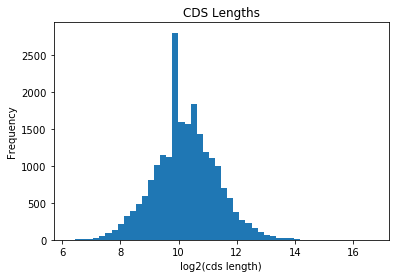

In [22]:
plt.hist(np.log2(np.array(cds_lengths) ), bins = 50);
plt.xlabel("log2(cds length)");
plt.ylabel("Frequency");
plt.title("CDS Lengths");

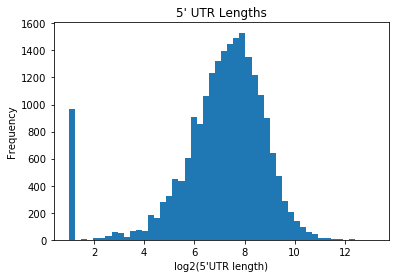

In [23]:
plt.hist(np.log2(np.array(utr5_lengths) + 2 ), bins = 50);
plt.xlabel("log2(5'UTR length)");
plt.ylabel("Frequency");
plt.title("5' UTR Lengths");

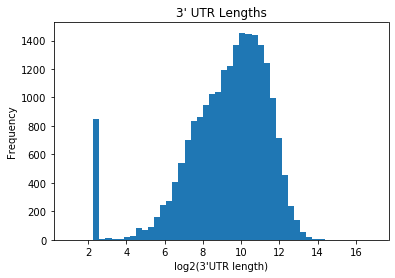

In [24]:
plt.hist(np.log2(np.array(utr3_lengths) + 2 ), bins = 50);
plt.xlabel("log2(3'UTR length)");
plt.ylabel("Frequency");
plt.title("3' UTR Lengths");

## Summary


We explored [Appris](https://academic.oup.com/nar/article/46/D1/D213/4561658) transcripts. Based on our observations, we decided to filter out some transcripts for our purposes. In particular, we followed the following steps:

1. We picked only "PRINCIPAL" entries and left "ALTERNATIVE" entries.
2. We picked only protein coding genes by choosing "gene_type protein_coding" in the GTF file.
3. We picked transcripts with the  *proper*\* start / stop codons.

These steps are mostly based on our 'Sanity Checks'.

Also, we discard Y chromosome paralogs of genes. They have "PAR_Y" in their gene ID in the gtf file and the fasta file

After filtering, we had a total of **{{ len(selected_transcripts) }} transcripts**.

* {{CDS_remainder_by_3[0]}} of these transcripts have CDS with length a multiple of 3. Whereas {{CDS_remainder_by_3[1] + CDS_remainder_by_3[2]}} of them don't.

* {{ start_triplets['ATG'] }} of them start with ATG (the start codon)

* The median length of the CDS regions is {{ median_cds_length }}. The average length is {{ mean_cds_length }}.

* There are {{ missing_utr5 }} transcripts missing 5' UTR and {{ missing_utr3 }} transcripts missing 3' UTR.

* In the Appris list, different transcripts of the same gene have identical sequences. There are a few exceptions to this. Even those excpetional cases differ in ~1 nucleotide position. This doesn't effect the mapping results significantly. Therefore, in case there are multiple principal isoform entries of the same gene, picking one arbitrarily doesn't make a noticeable difference.

--------------
\*Proper start codons are those that are 1 nucleotide away from the codon ATG.

## Files and Hash Sums

Appris list was downloaded from : http://appris-tools.org/#/downloads
on November 4, 2020

GENCODE:

All other files have been downloaded from gencode website: [https://www.gencodegenes.org/human/](https://www.gencodegenes.org/mouse/)

Version: m25

In [25]:
! zcat  ../raw/sequence/gencode.vM25.pc_transcripts.fa.gz | md5sum

f4b7f34cdf2265d80c26b7ca5420c6ec  -


In [26]:
! zcat ../raw/annotation/gencode.vM25.annotation.gtf.gz | md5sum

75cb25c2d2ef1faaeaf0a86b67e38e61  -


In [29]:
! md5sum ../raw/annotation/appris_data.principal.txt

1ae086d1aa384127c4afe00918f22f7f  ../raw/annotation/appris_data.principal.txt


## Generating RiboFlow Reference and Annotation

If the riboflow reference and annotation has not already been generated, you can run the 'generate_riboflow_ref_and_annot.sh' inside the scripts folder.